# Explore here

Author: John Fredy Beltran Cuellar  
Date: 10/05/2025  
Goal: Clasificador de Vinos con KNN  

In [2]:
# ========================================
# Step 0. Importar librerías
# ========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV


In [3]:
# ========================================
# Step 1. Cargar dataset (df_raw)
# ========================================
url = "https://raw.githubusercontent.com/4GeeksAcademy/k-nearest-neighbors-project-tutorial/refs/heads/main/winequality-red.csv"
df_raw = pd.read_csv(url, sep=";")
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
df_raw.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
377,9.4,0.270,0.53,2.4,0.074,6.0,18.0,0.99620,3.20,1.13,12.0,7
1120,7.9,0.540,0.34,2.5,0.076,8.0,17.0,0.99235,3.20,0.72,13.1,8
416,10.6,0.480,0.64,2.2,0.111,6.0,20.0,0.99700,3.26,0.66,11.7,6
476,9.3,0.270,0.41,2.0,0.091,6.0,16.0,0.99800,3.28,0.70,9.7,5
415,8.6,0.725,0.24,6.6,0.117,31.0,134.0,1.00140,3.32,1.07,9.3,5
1267,10.4,0.430,0.50,2.3,0.068,13.0,19.0,0.99600,3.10,0.87,11.4,6
139,7.8,0.560,0.19,2.0,0.081,17.0,108.0,0.99620,3.32,0.54,9.5,5
1248,6.9,0.410,0.33,2.2,0.081,22.0,36.0,0.99490,3.41,0.75,11.1,6
711,8.9,0.565,0.34,3.0,0.093,16.0,112.0,0.99980,3.38,0.61,9.5,5
702,7.0,0.640,0.02,2.1,0.067,9.0,23.0,0.99700,3.47,0.67,9.4,6


In [5]:
# Step 2. Preprocessing (df_baking)
# ========================================
df_baking = df_raw.copy()

# Limpieza de posibles comillas en los nombres de columnas
df_baking.columns = df_baking.columns.str.replace('"', '').str.strip()
df_baking.columns = df_baking.columns.str.replace(" ", "_")
df_baking = df_baking.drop(columns=["quality"])
df= df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
dtypes: float64(11)
memory usage: 137.5 KB


In [6]:
# Step 3: EDA
df_train, df_test = train_test_split(df, test_size=0.1, random_state=2025)
df_train, df_val = train_test_split(df_train, test_size=0.15, random_state=2025)

# Reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train.shape, df_val.shape, df_test.shape

((1223, 11), (216, 11), (160, 11))

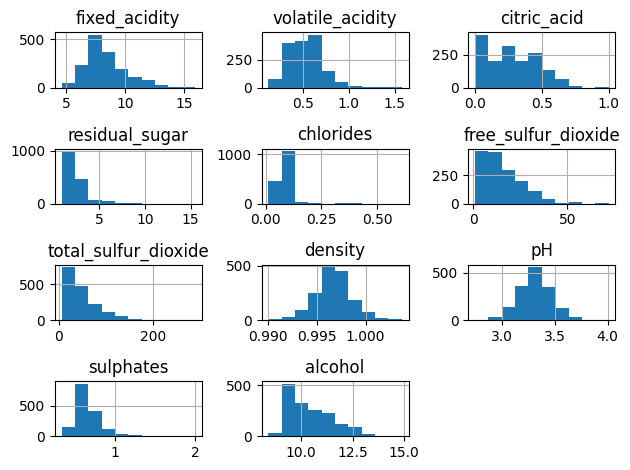

In [7]:
df.hist()
plt.tight_layout()
plt.show()


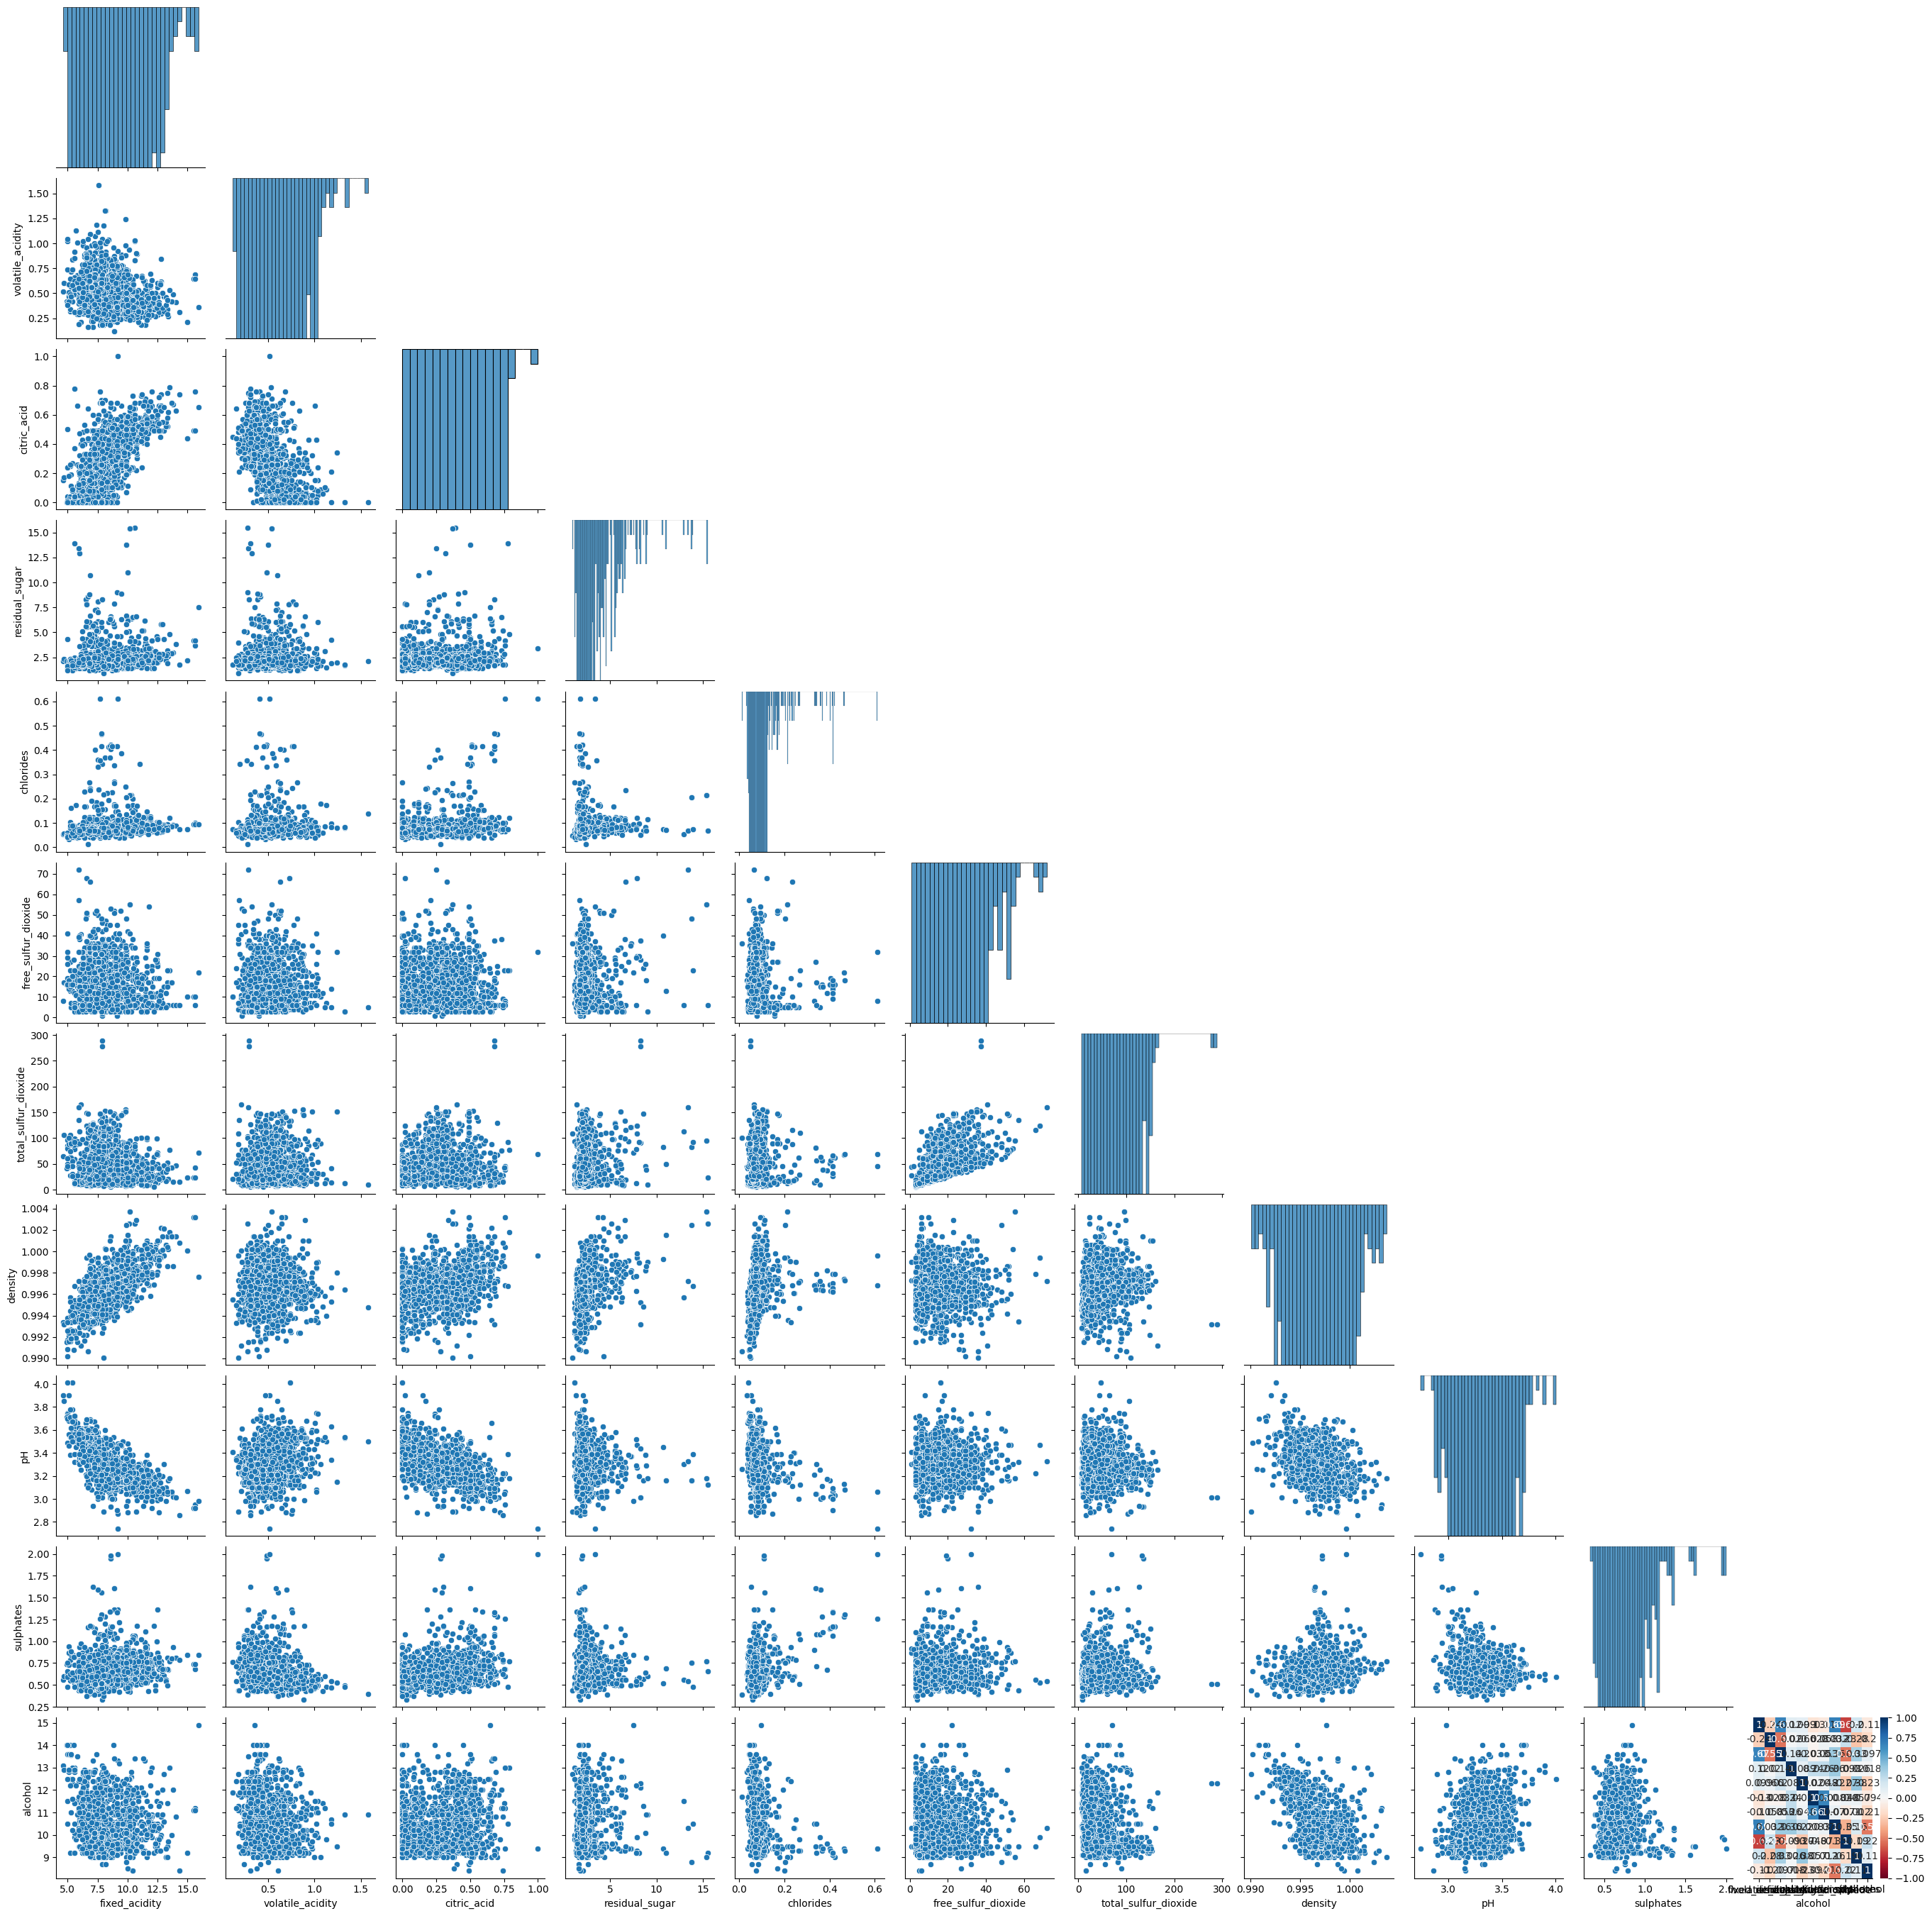

In [8]:
sns.pairplot(df, corner=True)
sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')
plt.show()

In [9]:
# Step 4. Machine Learning (KNN)
# ========================================
# -------------------------
# Target original
y = df_raw["quality"]

# Features
X_train = df_train.copy()
X_val = df_val.copy()
X_test = df_test.copy()
y_train = y.loc[X_train.index]
y_val = y.loc[X_val.index]
y_test = y.loc[X_test.index]


In [10]:
# Step 4b: Escalar datos
# -------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Step 4c: Entrenar KNN
# -------------------------
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [12]:
# Step 4d: Evaluar modelo
# -------------------------
y_pred_val = knn.predict(X_val_scaled)
y_pred_test = knn.predict(X_test_scaled)

print("Accuracy Validation:", accuracy_score(y_val, y_pred_val))
print("Accuracy Test:", accuracy_score(y_test, y_pred_test))

print("\nClassification Report (Validation):\n", classification_report(y_val, y_pred_val, zero_division=0))
print("\nConfusion Matrix (Validation):\n", confusion_matrix(y_val, y_pred_val))


Accuracy Validation: 0.5138888888888888
Accuracy Test: 0.46875

Classification Report (Validation):
               precision    recall  f1-score   support

           4       0.00      0.00      0.00        12
           5       0.70      0.64      0.67       138
           6       0.24      0.36      0.29        55
           7       0.40      0.18      0.25        11

    accuracy                           0.51       216
   macro avg       0.33      0.30      0.30       216
weighted avg       0.53      0.51      0.51       216


Confusion Matrix (Validation):
 [[ 0  3  9  0]
 [ 0 89 48  1]
 [ 0 33 20  2]
 [ 0  3  6  2]]


In [13]:
# Step 4e: Optimizar k con GridSearchCV
# ========================================
param_grid = {'n_neighbors': list(range(1, 21))}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print("Mejor k encontrado:", grid.best_params_['n_neighbors'])
print("Mejor score CV:", grid.best_score_)


Mejor k encontrado: 18
Mejor score CV: 0.40881900301104046


In [14]:
# Entrenar KNN con el mejor k
knn_best = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
knn_best.fit(X_train_scaled, y_train)

,n_neighbors,18
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [15]:
# Evaluación del modelo optimizado
y_pred_val_best = knn_best.predict(X_val_scaled)
y_pred_test_best = knn_best.predict(X_test_scaled)

print("\nAccuracy Validation (mejor k):", accuracy_score(y_val, y_pred_val_best))
print("Accuracy Test (mejor k):", accuracy_score(y_test, y_pred_test_best))
print("\nClassification Report (Validation) con mejor k:\n", classification_report(y_val, y_pred_val_best, zero_division=0))
print("\nConfusion Matrix (Validation) con mejor k:\n", confusion_matrix(y_val, y_pred_val_best))



Accuracy Validation (mejor k): 0.4583333333333333
Accuracy Test (mejor k): 0.48125

Classification Report (Validation) con mejor k:
               precision    recall  f1-score   support

           4       0.00      0.00      0.00        12
           5       0.62      0.59      0.60       138
           6       0.21      0.33      0.26        55
           7       0.00      0.00      0.00        11

    accuracy                           0.46       216
   macro avg       0.21      0.23      0.21       216
weighted avg       0.45      0.46      0.45       216


Confusion Matrix (Validation) con mejor k:
 [[ 0  7  5  0]
 [ 0 81 57  0]
 [ 0 37 18  0]
 [ 0  6  5  0]]


In [16]:
# Step 5: Predicción con un ejemplo nuevo
# ========================================
nuevo_vino = np.array([[7.4, 0.7, 0, 1.9, 0.076, 11, 34, 0.9978, 3.51, 0.56, 9.4]])
nuevo_vino_scaled = scaler.transform(nuevo_vino)
prediccion = knn_best.predict(nuevo_vino_scaled)
print("Predicción calidad vino nuevo:", prediccion[0])

Predicción calidad vino nuevo: 5


/workspaces/K-NEAREST-NEIGHBORS/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


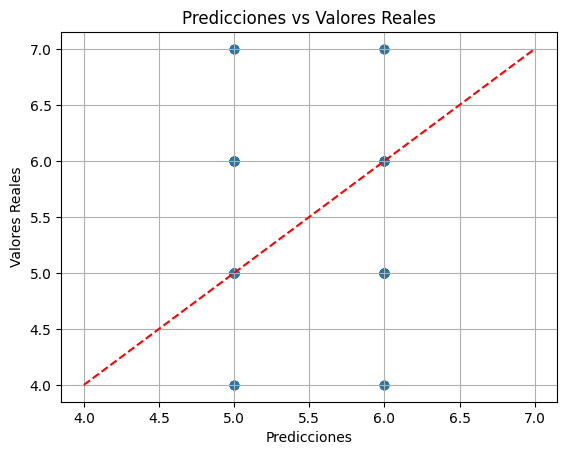

In [17]:
# Step 6: Visualización Predicciones vs Real
# ========================================
plt.scatter(x=y_pred_val_best, y=y_val, alpha=0.6)
plt.grid(True)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], c='r', linestyle='--')
plt.title("Predicciones vs Valores Reales")
plt.show()

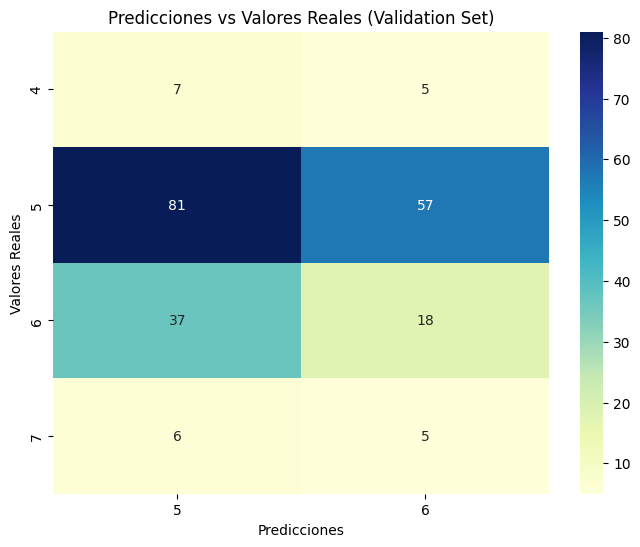

In [18]:
# Crear un DataFrame con predicciones y valores reales
df_plot = pd.DataFrame({
    'Predicciones': y_pred_val_best,
    'Valores_Reales': y_val
})

# Contar ocurrencias para cada combinación predicción/real
heatmap_data = df_plot.groupby(['Valores_Reales', 'Predicciones']).size().unstack(fill_value=0)

# Graficar heatmap
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Predicciones vs Valores Reales (Validation Set)')
plt.show()

In [19]:
# validacion de otros modelos
clf_tree = Pipeline([
    ('proc', MinMaxScaler()),
    ('tree', DecisionTreeRegressor(max_depth=6,random_state=2025))
])

clf_rf = Pipeline([
    ('proc', MinMaxScaler()),
    ('rf', RandomForestRegressor(random_state=2025))
])

clf_hb = Pipeline([
    ('proc', MinMaxScaler()),
    ('hb', HistGradientBoostingRegressor(random_state=2025))
])

param_grids = {
    'tree':{
        'tree__max_depth':[2,4,5,6,7],
        'tree__min_samples_split':[2,4,6],
    },
    'rf':{
        'rf__max_depth':[2,4,5,6,7],
        'rf__min_samples_split':[2,4,6],
        'rf__n_estimators':[50,100,150,200]
    },
    'hb':{
        'hb__max_depth':[2,4,5,6,7]
    }
}

models = [
          (clf_tree,'Decission Tree', 'tree'),
          (clf_rf,'Random Forest', 'rf'),
          (clf_hb,'Histogram GBoosting', 'hb')
]

performance = {}
for est, name, sname in models:
  print(est, name, sname)
  est.fit(X_train, y_train)
  estimator_cv = GridSearchCV(
      est,
      param_grid = param_grids[sname],
      cv = 5
  )
  estimator_cv.fit(X_train, y_train)
  y_hat = estimator_cv.predict(X_val)
  mse = round(mean_squared_error(y_val, y_hat))
  r2 = round(r2_score(y_val, y_hat), 2)
  best_params = estimator_cv.best_params_
  performance[name] = {
      'MSE': mse,
      'R2 Score': r2,
      'Best Params': best_params,
      'estimator': estimator_cv.best_estimator_
  }

Pipeline(steps=[('proc', MinMaxScaler()),
                ('tree',
                 DecisionTreeRegressor(max_depth=6, random_state=2025))]) Decission Tree tree


Pipeline(steps=[('proc', MinMaxScaler()),
                ('rf', RandomForestRegressor(random_state=2025))]) Random Forest rf
Pipeline(steps=[('proc', MinMaxScaler()),
                ('hb', HistGradientBoostingRegressor(random_state=2025))]) Histogram GBoosting hb


RMSE: 0.75
R2: -0.34


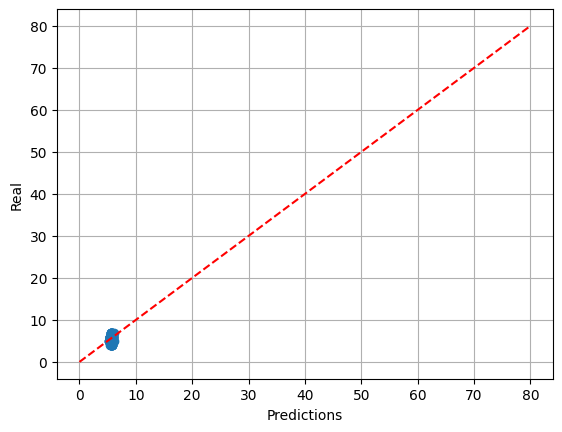

In [20]:
# Tree
rforest_reg_cv = RandomForestRegressor(max_depth=7, n_estimators=200,random_state=2025)
rforest_reg_cv.fit(X_train, y_train)
y_hat = rforest_reg_cv.predict(X_val)

print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_hat)):.2f}')
print(f'R2: {r2_score(y_val, y_hat):.2f}')

plt.scatter(x=y_hat, y=y_val)
plt.grid(True)
plt.xlabel('Predictions')
plt.ylabel('Real')
plt.plot([0, 80], [0, 80], c='r', linestyle='--', )
plt.show()

RMSE: 0.81
R2: -0.56


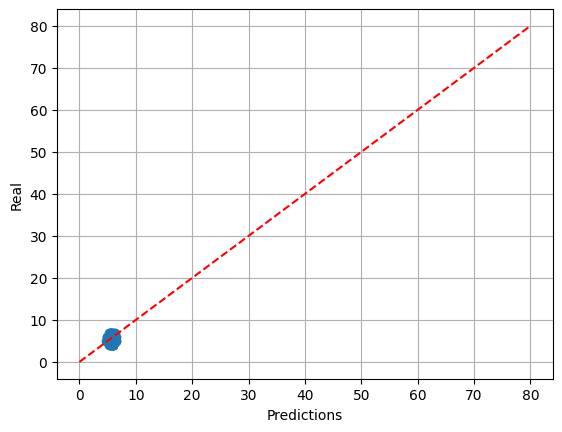

In [21]:
# Random Forest
hb_reg_cv = HistGradientBoostingRegressor(max_depth=7)
hb_reg_cv.fit(X_train, y_train)
y_hat = hb_reg_cv.predict(X_val)

print(f'RMSE: {np.sqrt(mean_squared_error(y_val, y_hat)):.2f}')
print(f'R2: {r2_score(y_val, y_hat):.2f}') 

plt.scatter(x=y_hat, y=y_val)
plt.grid(True)
plt.xlabel('Predictions')
plt.ylabel('Real')
plt.plot([0, 80], [0, 80], c='r', linestyle='--', )
plt.show()